# Face-Based Food Recommendation

### Stony Brook Health Hacks 2016
Food recommendations based on emotion

In [61]:
from bs4 import BeautifulSoup
from IPython.display import Image
from scipy import ndimage
from PIL import Image as img
import matplotlib.pyplot as plt
import numpy as np
import requests
import re
import urllib2
import os
import sys
import random

## Gathering Data
First we scrape images from google

In [62]:
def get_soup(url,header):
    """
    BeautifulSoup function
    """
    return BeautifulSoup(urllib2.urlopen(urllib2.Request(url,headers=header)),'lxml')

def scrape(mood):
    """
    Scrapes images related to specified mood
    """
    searches = ["boy","girl","man","woman","person","human","guy","gal","facial expression"]

    for search in searches:
        qname = mood + " " + search
        # you can change the query for the image  here  
        query= '+'.join(qname.split())
        url="https://www.google.co.in/search?q="+query+"&source=lnms&tbm=isch"
        #print url
        header = {'User-Agent': 'Mozilla/5.0'} 
        soup = get_soup(url,header)

        images = [a['src'] for a in soup.find_all("img", {"src": re.compile("gstatic.com")})]
        directory = "./" + mood
        if not os.path.exists(directory):
            os.mkdir(directory)
        #print images
        for i in range(len(images)):
          raw_img = urllib2.urlopen(images[i]).read()
          f = open(directory + "/" + qname +str(i)+".jpg", 'wb')
          f.write(raw_img)
          f.close()


In [63]:
moods = ["happy","sad","angry","disgusted","scared"]
for mood in moods:
    #scrape(mood)
    continue

Let's look at a few of the images we've scraped

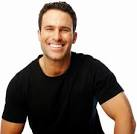

In [64]:
Image(filename="./happy/happy man2.jpg")

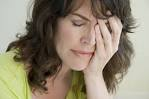

In [65]:
Image(filename="./sad/sad woman5.jpg")

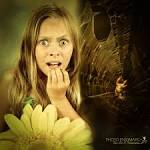

In [66]:
Image(filename="./scared/scared girl5.jpg")

## Formatting Data
The images are different sizes and not in usable format

We start by resizing

In [67]:
image_size = 128
resized_pics = []
label = []

for mood in moods:
    for pic in os.listdir("./" + mood):
        try:
            if("Resized" in pic):
                continue
            image = img.open("./" + mood + "/" + pic)
            image = image.resize((image_size,image_size),img.ANTIALIAS)
            newfile = "./" + mood + "/" + "Resized " + pic
            image.save(newfile)
            resized_pics.append(newfile)
            label.append(moods.index(mood))
        except IOError:
            continue

print "Pics: " + str(len(resized_pics))

Pics: 884


Take another look

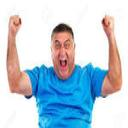

In [68]:
Image(filename="./happy/Resized happy man4.jpg")

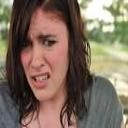

In [69]:
Image(filename="./disgusted/Resized disgusted woman5.jpg")

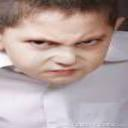

In [70]:
Image(filename="./angry/Resized angry boy12.jpg")

Next we can convert our data into a usable format

In [71]:
### Largely based on tensorflow doc

pixel_depth = 255.0  # Number of levels per pixel.
def load_pics(resized_pics):
  """Load the data for a single letter label."""
  image_files = resized_pics
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  image_index = 0
  for image in resized_pics:
    image_file = image
    try:
      image_data = (ndimage.imread(image_file,flatten=True).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[image_index, :, :] = image_data
      image_index += 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
    

In [72]:
dataset = load_pics(resized_pics)

('Full dataset tensor:', (884, 128, 128))
('Mean:', 0.10405602)
('Standard deviation:', 0.32121101)


Another quick look

Label: angry


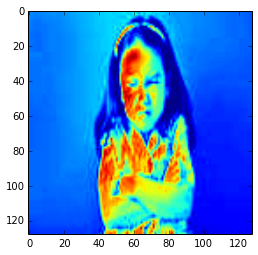

In [73]:
%matplotlib inline
plt.imshow(dataset[506])
print("Label: " + moods[label[506]])

Label: happy


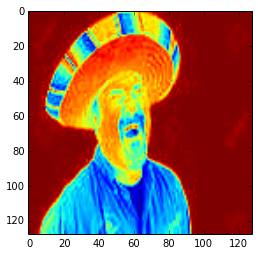

In [75]:
plt.imshow(dataset[23])
print("Label: " + moods[label[23]])

Flatten our dataset for easier use

In [76]:
X = np.resize(dataset,(len(dataset),image_size*image_size))
print("Shape: " + str(X.shape))

Shape: (884, 16384)


Next we convert our labels to one-hot encoding. This makes them easier to use and more intuitive in a neural network

In [77]:
def getindex(onehot):
    ret = np.where(onehot == 1)[0][0]
    return ret

newlabels = []
for index in label:
    newlabels.append([1 if i==index else 0 for i in range(5)])
    
y = np.array(newlabels,dtype=np.float32)
print "Shape: " + str(y.shape)
print "Example: " + str(y[422]) + " -> " + moods[getindex(y[422])]

Shape: (884, 5)
Example: [ 0.  0.  1.  0.  0.] -> angry


Finally we shuffle the data and separate test/train sets

In [78]:
random_indices = range(len(X))
random.shuffle(random_indices)

new_X = []
new_y = []

for i in random_indices:
    new_X.append(X[i])
    new_y.append(y[i])

div = 4*len(X)/5
    
X = np.array(new_X)
X_train = X[:div]
X_test = X[div:]
y = np.array(new_y)
y_train = y[:div]
y_test = y[div:]

print("Training: " + str(len(X_train)))
print("Testing: " + str(len(X_test)))

Training: 707
Testing: 177


## Training a neural network

In [79]:
import tensorflow as tf

In [127]:
breadth = 128

graph = tf.Graph()
with graph.as_default():
    
    # Input Data
    # Load our data into constants attached to the graph
    tf_X = tf.constant(X_train)
    tf_y = tf.constant(y_train, dtype=tf.float32)
    tf_X_Test = tf.constant(X_test)
    tf_y_Test = tf.constant(y_test, dtype=tf.float32)
    
    # Variables
    # Weights and biases for our layer
    w1 = tf.Variable(tf.truncated_normal([image_size*image_size,breadth]))
    b1 = tf.Variable(tf.zeros([breadth]))
    w2 = tf.Variable(tf.truncated_normal([breadth,len(moods)]))
    b2 = tf.Variable(tf.zeros([len(moods)]))
    
    # Logits
    def logits_calc(x):
        a1 = tf.nn.relu(tf.matmul(x,w1) + b1)
        logits = tf.matmul(a1,w2) + b2
        return logits
    logits = logits_calc(tf_X)
    
    # Loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits,tf_y)) + (.1)*tf.nn.l2_loss(w1) + (.1)*tf.nn.l2_loss(w2)+ (.1)*tf.nn.l2_loss(b1) + (.1)*tf.nn.l2_loss(b2)
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits)
    test_logits = logits_calc(tf_X_Test)
    test_prediction = tf.nn.softmax(test_logits)
    
    

In [128]:
# To measure model accuracy
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [130]:
w1_f = []
b1_f = []
w2_f = []
b2_f = []

num_steps = 101

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print "Initialized"
    for step in range(num_steps):
        _,l,predictions = session.run([optimizer,loss,train_prediction])
        if (step%20 == 0):
            print("loss @ step %d: %f" % (step,l))
            print("accuracy: %.1f%%" % accuracy(predictions, y_train))
    t = test_prediction.eval()
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), y_test))   
    w1_f = w1.eval()
    w2_f = w2.eval()
    b1_f = b1.eval()
    b2_f = b2.eval()

Initialized
loss @ step 0: 81595.734375
accuracy: 13.9%
loss @ step 20: 54356.375000
accuracy: 43.4%
loss @ step 40: 36337.046875
accuracy: 61.2%
loss @ step 60: 24302.226562
accuracy: 75.1%
loss @ step 80: 16255.364258
accuracy: 97.3%
loss @ step 100: 10874.440430
accuracy: 98.7%
Test accuracy: 42.9%


Our model is stored in the weights (w1_f,w2_f) and bias' (b1_f,b2_f). We define function to classify using these values

In [131]:
def classify(X):
    """
    X is a matrix of any number of rows, image_size^2 columns
    Runs through the neural net
    """
    sess = tf.InteractiveSession()
    x = tf.constant(X)
    w1 = tf.constant(w1_f)
    b1 = tf.constant(b1_f)
    w2 = tf.constant(w2_f)
    b2 = tf.constant(b2_f)
    a1 = tf.nn.relu(tf.matmul(x,w1) + b1)
    logits = tf.matmul(a1,w2) + b2
    prediction = tf.nn.softmax(logits)
    return prediction.eval()

disgusted


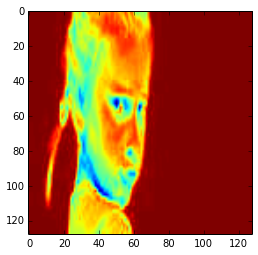

In [133]:
example = X_test[7:8]

label = moods[np.argmax(classify(example))]


example = np.resize(example,(128,128))
plt.imshow(example)
print label


## Mapping to food
We will choose a food based on mood

In [134]:
def get_food(index):
    path = "./foods/"
    foods = [["greens.jpeg"],["icecream.jpeg"],["nutsandseeds.jpeg"],["bread.jpeg"],["banana.jpeg"]]
    return Image(path+foods[index][0])

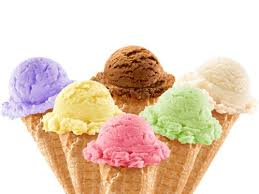

In [135]:
get_food(1)

## An example
Sad Donald Knuth

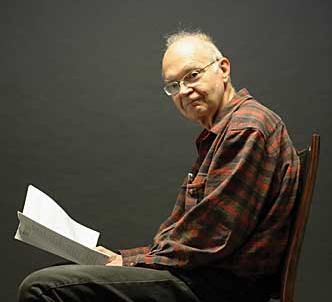

In [136]:
Image("./ex/saddon.jpeg")

In [137]:
# Format pic
image = img.open("./ex/saddon.jpeg")
image = image.resize((image_size,image_size),img.ANTIALIAS)
newfile = "./resizedsaddon.jpeg"
image.save(newfile)
pic_vals = load_pics([newfile])
pic_X = np.resize(pic_vals,(1,image_size*image_size))

('Full dataset tensor:', (1, 128, 128))
('Mean:', -0.23026453)
('Standard deviation:', 0.17492631)


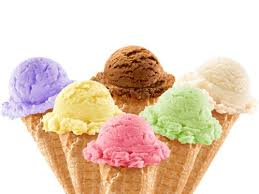

In [138]:
index = classify(pic_X)
get_food(np.argmax(index))

4 sad don